In [1]:
import sys

from IPython.display import Image, display
if 'google.colab' in sys.modules:
    from google.colab import drive
    drive.mount('/content/drive')

%cd '/content/drive/MyDrive/Inteligencia Artificial/IA - Clases de Práctica/ContenidosPorTemas/ActividadesPracticas/Ensambles'

[Errno 2] No such file or directory: '/content/drive/MyDrive/Inteligencia Artificial/IA - Clases de Práctica/ContenidosPorTemas/ActividadesPracticas/Ensambles'
/workspaces/IA/_8_Ensambles


/home/codespace/.local/lib/python3.10/site-packages/IPython/core/magics/osm.py:393: UserWarning: using bookmarks requires you to install the `pickleshare` library.
  bkms = self.shell.db.get('bookmarks', {})


# Ensambles de Clasificadores

La idea clave en los ensambles es lograr **diversidad** en los clasificadores del conjunto. Esta diversidad puede lograrse de distintas maneras.
El método más común consiste en usar distintos conjuntos de entrenamiento para entrenar clasificadores individuales. Estos conjuntos se pueden obtener mediante muestreo aleatorio de los datos de entrenamiento.
> Cuando el muestreo se realiza con reemplazo, el método de ensamble se denomina **bagging** (boostrap aggregating). Cuando el muestreo se hace sin reemplazo se denomina **pasting**

Todos los ensambles deben tener 2 componentes principales: Un algoritmo para generar clasificadores diversos y un método para combinar las salidas de los clasificadores. El método más comun para combinar las salidas es la **votación por mayoría**

## Bagging (Bootstrap aggregation)
En esta estrategia, la diversidad del ensamble se obtiene mediante subconjuntos muestreados de forma aleatoria del conjunto de datos original con reemplazo (pueden repetirse los datos). Estos subconjuntos, se utilizan para entrenar diferentes **clasificadores del mismo tipo**. La predicción final, se obtiene a partir de las predicciones individuales utilizando en general **_votación por mayoría_**.
El proceso de muestreo de los datos con reemplazo se denomina **Bootstrap**

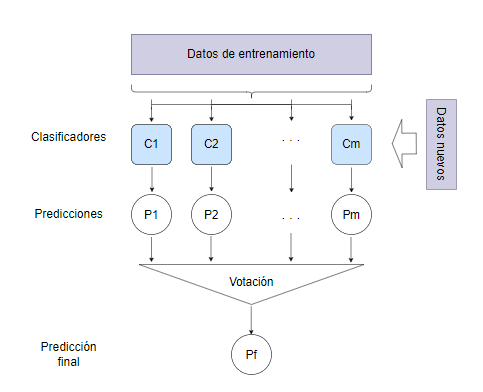

In [2]:
display(Image(filename='./2_imagenes/bagging.png', width=700))

In [3]:
from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split
from modulos.graficacion import plot_decision_regions
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier
import matplotlib.pyplot as plt
import numpy as np

# Creamos datos
X, y = make_moons(n_samples=500, noise=0.30, random_state=2)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=2, stratify=y)

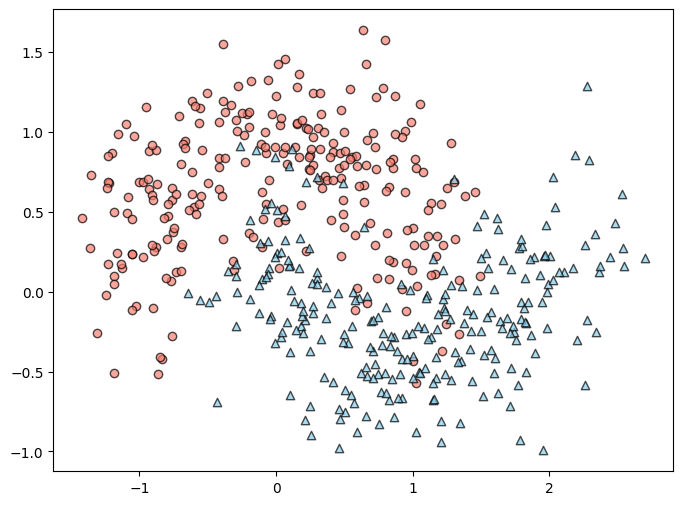

In [4]:
# Visualizamos los datos
markers = ('o', '^', 'v')
colors = ('salmon','skyblue','red', 'gray', 'cyan')
plt.figure(figsize=(8,6))
for idx, cl in enumerate(np.unique(y)):
    plt.scatter(x=X[y == cl, 0],
                y=X[y == cl, 1],
                alpha=0.7,
                c=colors[idx],
                marker=markers[idx],
                label=cl,
                edgecolor='black')

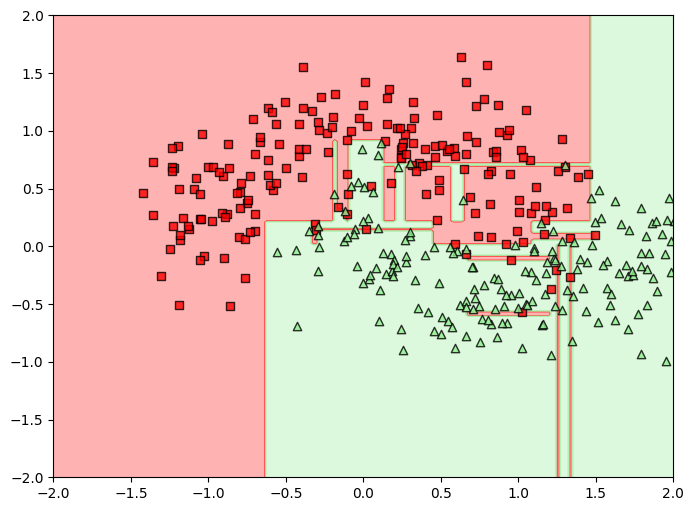

In [5]:
tree_clf = DecisionTreeClassifier(random_state=2)
tree_clf.fit(X_train, y_train)

# Graficación
plt.figure(figsize=(8,6))
plot_decision_regions(X_train, y_train, tree_clf)
plt.xlim(-2,2)
plt.ylim(-2,2)
plt.show()

In [6]:
print(tree_clf.score(X_test, y_test))

0.792


**Vamos a comparar el entrenamiento de un árbol de decisión con un ensamble de árboles**

**Armamos un ensamble combinando 50 árboles de decisión**

Creamos el ensamble usando la clase **_BaggingClassifier_** implementado en el módulo scikit-Learn. Este módulo nos permite seleccionar la técnica de ensamble entre bagging o pasting en función de cómo se seleccionan los parámetros:

1. Cuando los subconjuntos se seleccionan de forma aleatoria particionando el dataset sin reemplazo, el algoritmo se conoce como **_Pasting_**
2. Cuando los subconjuntos se seleccionan de forma aleatoria particionando el dataset **_con_** reemplazo, el algoritmo se conoce como **_Bagging_**
3. Cuando los subconjuntos tienen diferentes características del dataset, el algoritmo se conoce como **_Random Subspaces_**
4. Cuando los subconjuntos combinan los dos anteriores, el algoritmo se conoce como **_Random Patches_**

In [7]:
from sklearn.ensemble import BaggingClassifier

bag_clf = BaggingClassifier(DecisionTreeClassifier(),
                            n_estimators=50,
                            max_samples=100,
                            max_features = 1.0,
                            bootstrap = True,
                            n_jobs=-1,
                            random_state=2)
bag_clf.fit(X_train, y_train)

BaggingClassifier(estimator=DecisionTreeClassifier(), max_samples=100,
                  n_estimators=50, n_jobs=-1, random_state=2)

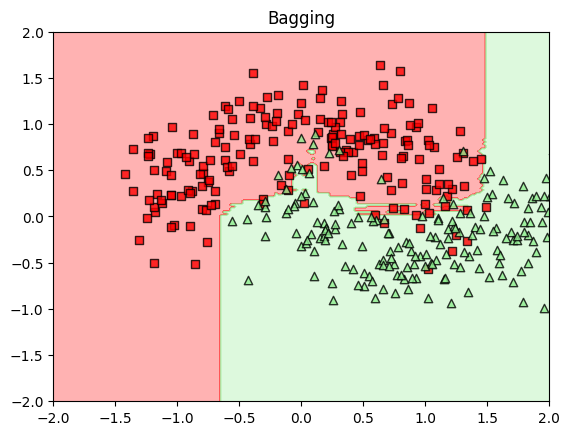

In [8]:
# plt.figure(figsize=())
plot_decision_regions(X_train, y_train, bag_clf)
plt.xlim(-2,2)
plt.ylim(-2,2)
plt.title("Bagging")
plt.ylabel("")

plt.show()

### Evaluación Out of bag (OOB)

Es una medida del desempeño aplicada a modelos que utilizan la técnica de **_Bootstrapping_**. En la selección de los datos para cada clasificador, durante su entrenamiento, alrededor del 36% de los datos no son muestreados. El desempeño OOB, representa el promedio de los desempeños de cada clasificador del ensamble cuando se tienen en cuenta estos datos que cada clasificador no ve durante el entrenamiento. Esta estrategia puede entenderse como una especie de validación cruzada y es efectiva para estimar la generalización del modelo.

In [9]:
bag_clf = BaggingClassifier(DecisionTreeClassifier(),
                            n_estimators=50,
                            max_samples=100,
                            max_features = 1.0,
                            bootstrap = True,
                            oob_score=True,
                            n_jobs=-1,
                            random_state=2)
bag_clf.fit(X_train, y_train)
bag_clf.oob_score_

0.904

In [10]:
print(bag_clf.score(X_test, y_test))

0.912


## Random Forest

En esta estrategia, los clasificadores son árboles de decisión y los subconjuntos de entrenamiento se eligen por **_Bootstrapping_** o **_Random Subspacing_**.
El número de árboles suele ser grande, generalmente entre 100 a 1000 árboles de decisión.

**Random Subspacing** genera subconjuntos de entrenamiento con diferentes características de forma aleatoria.

Mediante el bootstrapping y random subspacing se introduce aletoriedad al algoritmo, haciendo que cada árbol se forme de manera ligeramente distinta ya que en la formación de los mismos cada uno parte de una muestra diferente y en cada nodo la selección de características cambia.

### Parámetros principales del modelo:

Este modelo depende principalmente de 2 parámetros:

- Número de árboles de decisión. En la función de scikit-learn por defecto es 100.
- Número de características (q) que se seleccionan en cada nodo y que permanece fijo en la formación del árbol. En la función de scikit-learn, toma por defecto $q=\sqrt{F}$ siendo F el número de características totales en el dataset.

Una Ventaja de Random Forest es que podemos estimar el desempeño sin necesidad de realizar validación cruzada, usando las muestras OOB.

In [11]:
from sklearn.ensemble import RandomForestClassifier

rnd_clf = RandomForestClassifier(n_estimators=50,
                                 max_samples=100,
                                 n_jobs=-1,
                                 max_features=None,
                                 random_state=2)
rnd_clf.fit(X_train, y_train)

RandomForestClassifier(max_features=None, max_samples=100, n_estimators=50,
                       n_jobs=-1, random_state=2)

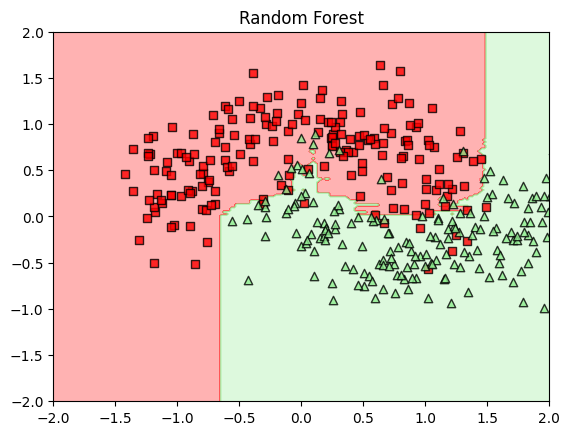

In [12]:
plot_decision_regions(X_train, y_train, rnd_clf)
plt.xlim(-2,2)
plt.ylim(-2,2)
plt.title("Random Forest")
plt.ylabel("")

plt.show()

In [13]:
print(rnd_clf.score(X_test, y_test))

0.912


## Boosting:

Boosting se refiere a la forma en como un ensamble puede potenciar (**boost**) un clasificador 'débil' para obtener uno más robusto. Un clasificador 'débil' es aquel que puede clasificar al menos un poco mejor que por decisión aleatoria (para un problema de 2 clases un error de clasificación >= 0.5).

En la estrategia de Bagging, los clasificadores se entrenan de forma independiente. En Boosting los clasificadores se entrenan en serie (consecutivamente) y la performance del clasificador _k_ influencia en el entrenamiento del _k+1_.

Como idea clave, el algoritmo se enfoca en las muestras mal clasificadas, de forma tal que estas sean muestreadas (**up-sampled**) cuando el siguiente clasificador es entrenado. Por lo tanto, los datos de entrenamiento de los clasificadores siguientes están orientados a instancias cada vez más difíciles de clasificar.

### Adaboost
Es el primer algoritmo que se volvió popular en 1997, creado por Freund y Schapire.

Los pasos del algoritmo se pueden describir de la siguiente manera:

- Se asigna inicialmente una distribución uniforme de pesos a todas las muestras del conjunto de entrenamiento.

    - Cada instancia del conjunto de entrenamiento tiene un peso $\frac{1}{m}$, con $m$ igual a la cantidad de instancias.

- Se selecciona un subconjunto de datos de entrenamiento (con reemplazo) de esta distribución para entrenar el primer clasificador y se obtiene la tasa de error de entrenamiento de dicho clasificador $r_1$:

$$r_j=\frac{\sum\limits_{\begin{matrix} i=1\\ y_{p}\neq y \end{matrix}}^{m}w^{(i)}}{\sum\limits_{i=1}^{m}w^{(i)}}$$

- Se le asigna un peso a cada clasificador $\alpha_j$, $\eta$ es un coeficiente de aprendizaje del algoritmo:

$$\alpha_j = \eta \log\frac{1-r_j}{r_j}$$

- Con este coeficiente se actualiza la distribución de los pesos asignados a las muestras usando el factor calculado $\alpha_j$. Esta actualización hace que las instancias mal clasificadas por el clasificador anterior se incluyan en los datos de entrenamiento del siguiente clasificador con mayor probabilidad. Es decir, se incrementan los pesos de las muestras mal clasificadas y se disminuyen los de las clasificadas correctamente.


$$w^{(i)} = w^{(i)} exp(\alpha_j), \qquad y_p^{(i)} \neq y^{(i)}$$

Adaboost usa un esquema de votación no democrático, denominado _weighted majority voting_: aquellos clasificadores que mostraron buena performance durante su entrenamiento son "recompensados" con pesos de votación más altos que los demás.

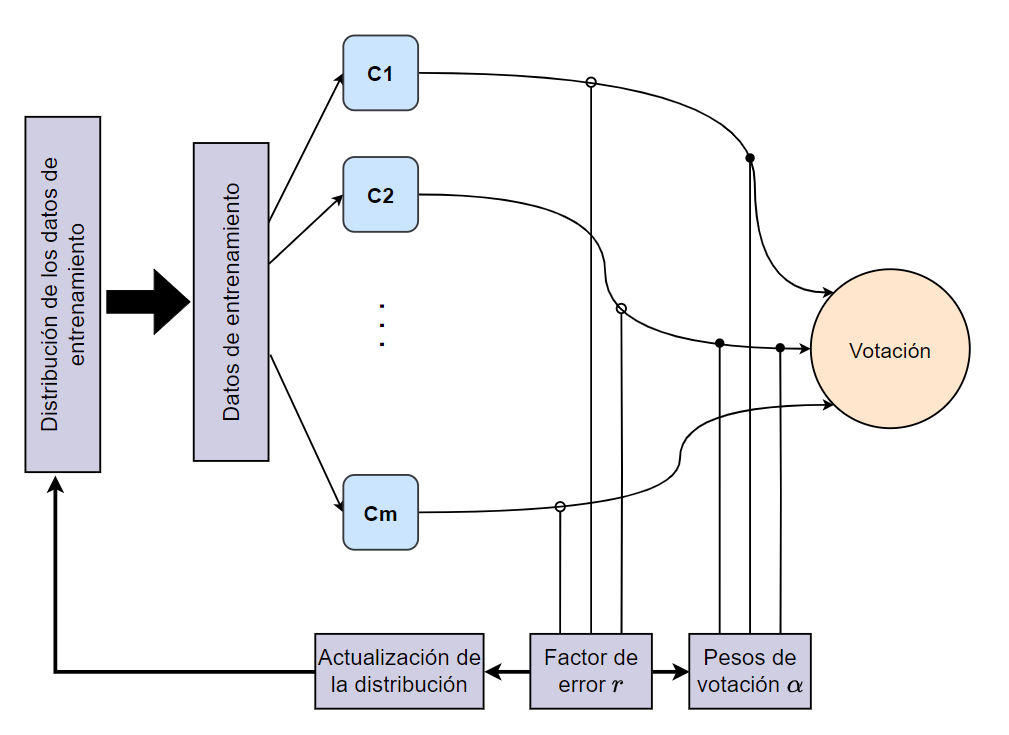

In [14]:
display(Image(filename='./2_imagenes/bootstrap.png', width=700))

Iteración 1:
pesos de instancias: [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
pesos de los mal clasificados: [1. 1. 1. 1. 1.]
pesos de los bien clasificados: [1. 1. 1. 1. 1.]
tasa de error de entrenamiento r: 0.07466666666666667
peso del clasificador: 2.517120269771655
pesos de los mal clasificados: [0.01785714 0.01785714 0.01785714 0.01785714 0.01785714]
pesos de los bien clasificados: [0.00144092 0.00144092 0.00144092 0.00144092 0.00144092]


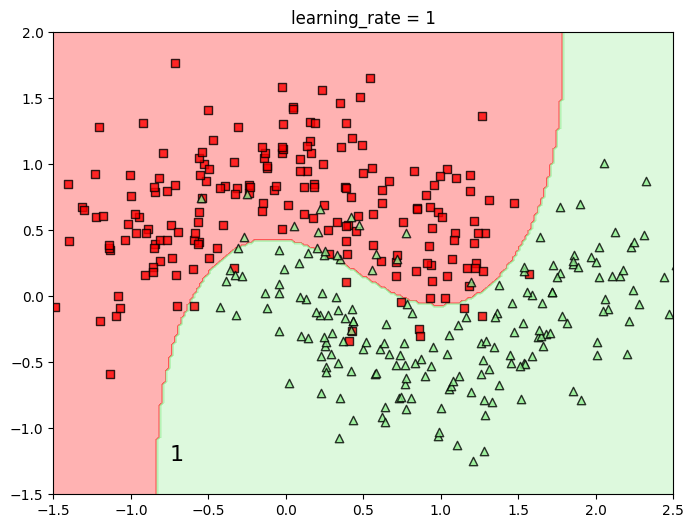

In [15]:
from sklearn.svm import SVC

X, y = make_moons(n_samples=500, noise=0.30, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

m = len(X_train)

plt.figure(figsize=(8,6))
learning_rate = 1

pesos_instancias = np.ones(m) / m

for i in range(1):
    print(f"Iteración {i+1}:")
    svm_clf = SVC(C=100, gamma=0.15)

    pesos_instancias = pesos_instancias * m
    print("pesos de instancias:", pesos_instancias[:10])

    svm_clf.fit(X_train, y_train, sample_weight=pesos_instancias)
    y_pred = svm_clf.predict(X_train)

    pesos_mal_clasificados = pesos_instancias[y_pred != y_train].sum()
    print("pesos de los mal clasificados:", pesos_instancias[y_pred != y_train][:5])
    print("pesos de los bien clasificados:", pesos_instancias[y_pred == y_train][:5])
    r = pesos_mal_clasificados / pesos_instancias.sum()
    print("tasa de error de entrenamiento r:", r)

    alpha = learning_rate * np.log((1 - r) / r)
    print("peso del clasificador:", alpha)

    #Actualización de los pesos
    pesos_instancias[y_pred != y_train] *= np.exp(alpha)
    #Se normalizan los pesos
    pesos_instancias /= pesos_instancias.sum()
    print("pesos de los mal clasificados:", pesos_instancias[y_pred != y_train][:5])
    print("pesos de los bien clasificados:", pesos_instancias[y_pred == y_train][:5])

    plot_decision_regions(X_train, y_train, svm_clf)

    plt.title(f"learning_rate = {learning_rate}")
    plt.text(-0.75, -1.25, "1", fontsize=16)
    # plt.text(-0.45, -1.25, "2", fontsize=16)
    # plt.text(0.5, -1.25, "3", fontsize=16)
    # plt.text(2, 1, "4", fontsize=16)
    # plt.text(2,  0.75, "5", fontsize=16)
plt.xlim(-1.5,2.5)
plt.ylim(-1.5,2)
plt.show()

sklearn utiliza una versión de AdaBoost llamada SAMME _(Stagewise Additive Modeling using a Multiclass Exponential loss function)_ Si los clasificadores en el ensamble pueden realizar predicciones mediante probabilidades, sklearn utiliza la variante SAMME.R que tiene en cuenta las probabilidades en lugar de las predicciones y generalmente obtiene mejores desempeños.

/home/codespace/.local/lib/python3.10/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


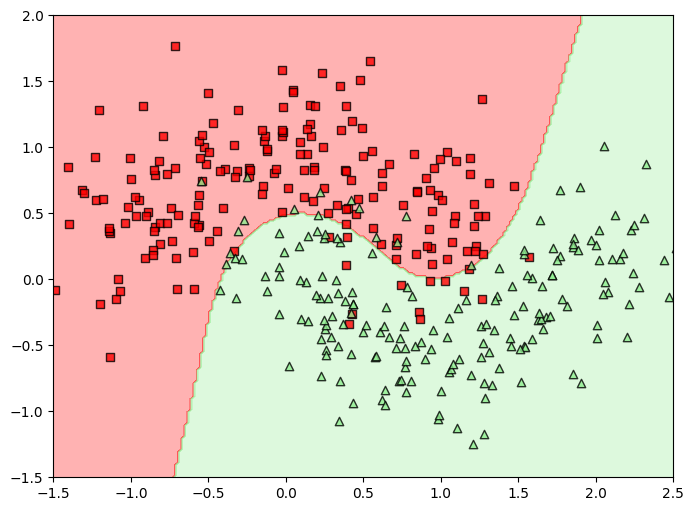

SVC score:
0.872
SVC Adaboost score:
0.928


In [16]:
from sklearn.ensemble import AdaBoostClassifier

X, y = make_moons(n_samples=500, noise=0.30, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

svc = SVC(
    C=100, probability=True, tol=1e-5, gamma=.9
)

ada_clf = AdaBoostClassifier( svc,
                              n_estimators=3,
                              learning_rate=0.9,
                              random_state=0
                             )

ada_clf.fit(X_train, y_train)

svc.fit(X_train, y_train)

plt.figure(figsize=(8,6))
plot_decision_regions(X_train, y_train, ada_clf)
plt.xlim(-1.5,2.5)
plt.ylim(-1.5,2)
plt.show()

print("SVC score:")
print(svc.score(X_test, y_test))
print("SVC Adaboost score:")
print(ada_clf.score(X_test, y_test))